In [89]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
import talib
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_sentiment = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [90]:

def get_stock_data(ticker, start='2020-01-01'):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
 # Display the first few rows


In [91]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [92]:
def train_lstm_model(X_train, y_train,X_test, y_test ,model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32,validation_data=(X_test, y_test), verbose=1, callbacks=[lr_scheduler])
    model.save(f"model{epoch}.keras")
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

# Sentiment Analysis
def get_sentiment_score(headline):
    inputs = tokenizer(headline, return_tensors='pt', truncation=True)
    outputs = model_sentiment(**inputs)
    probs = outputs.logits.softmax(dim=1).detach().numpy()[0]
    neg, neu, pos = probs
    return pos - neg

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test, y_test = X[-forecast_days:], y[-forecast_days:]

    try:
        model = load_model(f"model{epoch}.keras")
    except:
        model = train_lstm_model(X_train, y_train, X_test, y_test, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
    y_actual[:, 0] = y_test  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [94]:
df = get_stock_data("RELIANCE.NS")  # Replace with your stock ticker
df 

Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,
Date,,,,,,,,,,,,
1996-10-04,3.546806,3.575635,3.464041,3.547736,180091079,39.823219,3.574891,3.737942,3.786975,3.805630,3.864338,3.443070
1996-10-07,3.477992,3.555177,3.357099,3.555177,272128046,36.037613,3.561314,3.724147,3.777601,3.805540,3.836982,3.432578
1996-10-08,3.492870,3.533788,3.376627,3.461252,196707309,37.422709,3.546435,3.711903,3.770608,3.805660,3.810190,3.426450
1996-10-09,3.538437,3.570985,3.482641,3.533788,175357589,41.594183,3.533509,3.697582,3.761847,3.805876,3.785623,3.426745
1996-10-10,3.633292,3.645381,3.511469,3.528208,194458201,49.187512,3.535834,3.687663,3.756435,3.806728,3.767145,3.433227
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28,1275.099976,1295.750000,1269.000000,1280.000000,18147129,57.700779,1268.424988,1234.701668,1245.083999,1360.224517,1319.400084,1164.914918
2025-04-01,1252.599976,1277.900024,1249.300049,1264.599976,12099648,50.443446,1269.799988,1235.918335,1244.088999,1359.195640,1319.661711,1169.903291


In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=250)


Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.0290 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 2/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 0.0035 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 3/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 0.0025 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 4/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 0.0018 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 5/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0015 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 6/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 0.0015 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 7/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 9.2842e-04 - val_loss: 9.3467e-04 - learning_rate: 0.0010
Epoch 8/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 9.3605e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 9/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 9.3488e-04 - val_loss: 0.0018 - l

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0326 - val_loss: 0.2810 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0036 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0022 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0012 - val_loss: 5.0894e-04 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 9.2900e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0010 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 9.6194e-04 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 9.3120e-04 - val_loss: 6.5476e-04 - learn

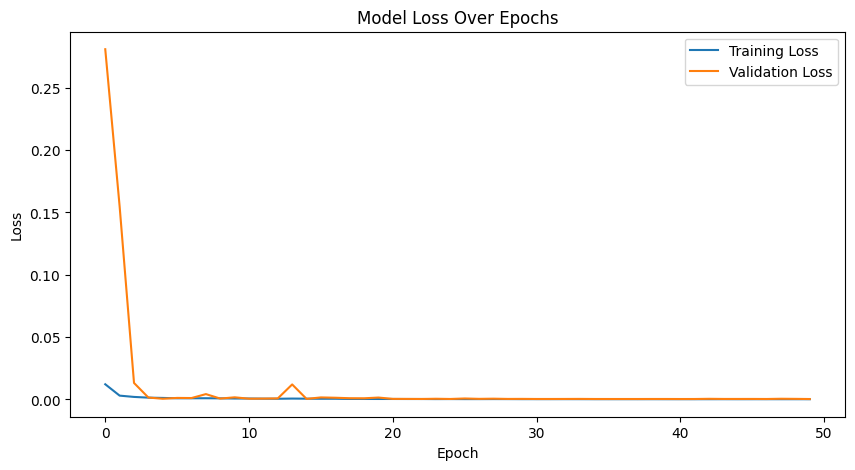

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
RMSE: 43.95838638228249
MAE: 36.740354222444935
MAPE: 3.010954828472356
R^2 Score: -0.6725536241594956


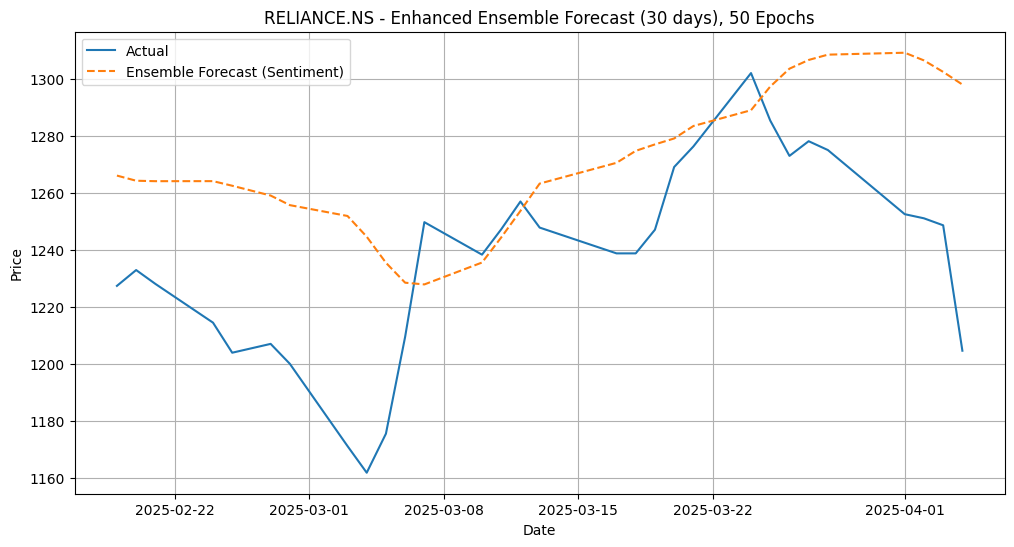

In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=50)




Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0253 - val_loss: 0.1840 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0033 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0024 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0012 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0011 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 8.4212e-04 - val_loss: 5.3773e-04 - learning_rate: 0.0010
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 9.3778e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 8.3775e-04 - val_loss: 0.0106 - l

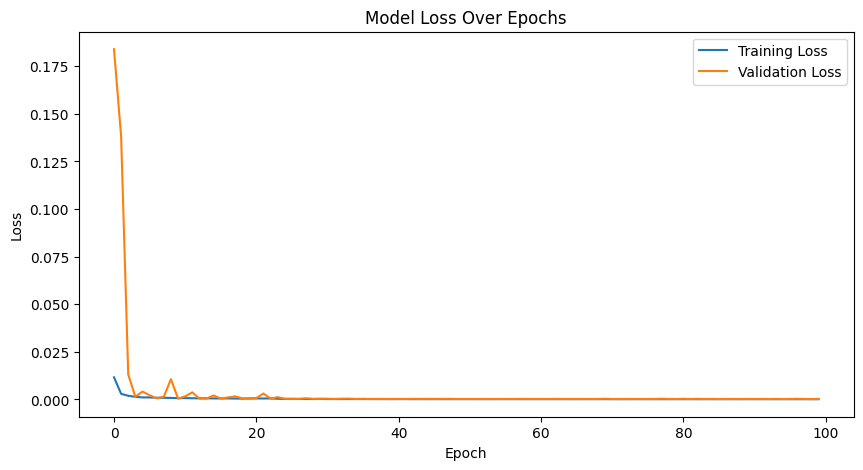

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
RMSE: 35.68190249701134
MAE: 30.879939983374683
MAPE: 2.5172549005868152
R^2 Score: -0.10202785243059709


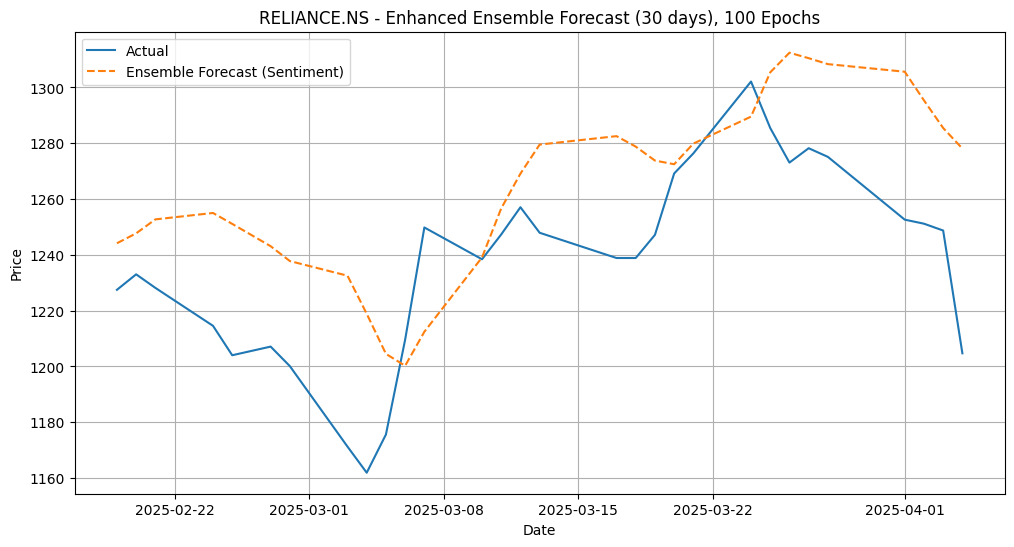

In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=100)


Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0396 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 2/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0044 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 3/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0023 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 4/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0016 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0015 - val_loss: 5.9649e-04 - learning_rate: 0.0010
Epoch 6/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0012 - val_loss: 5.1221e-04 - learning_rate: 0.0010
Epoch 7/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0011 - val_loss: 5.2570e-04 - learning_rate: 0.0010
Epoch 8/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0010 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 9/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 8.7674e-04 - val_loss: 5.2819e-04

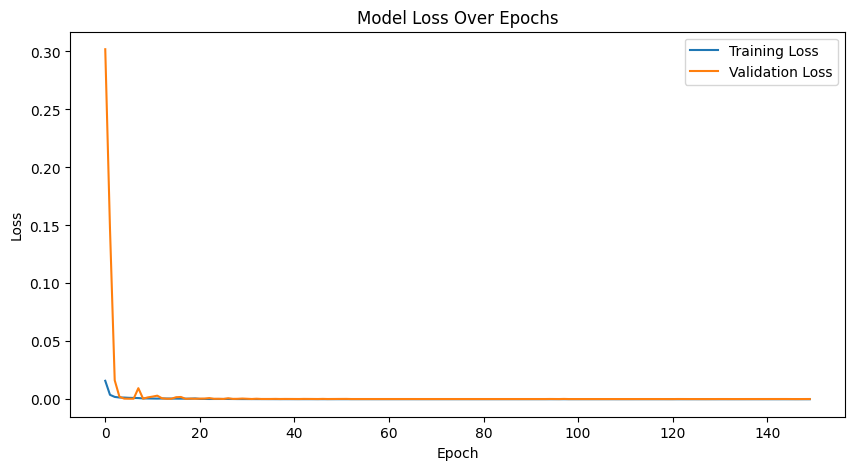

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
RMSE: 51.20548598743131
MAE: 46.78021666954692
MAPE: 3.8077325512377413
R^2 Score: -1.2694966777725818


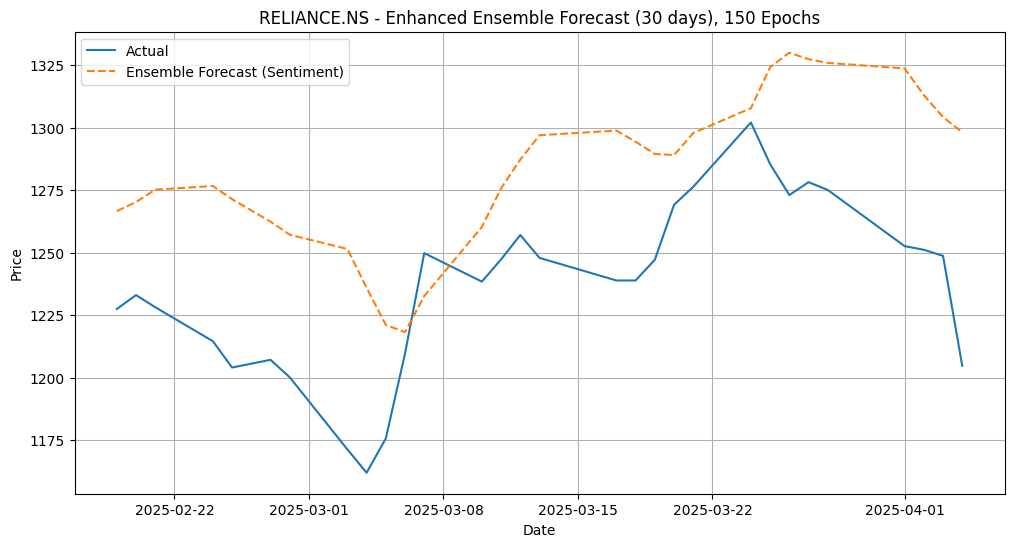

In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=150)


In [ ]:
forecast_ensemble("RELIANCE.NS",epoch=200)

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0240 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0029 - val_loss: 0.2200 - learning_rate: 0.0010
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0018 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0016 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0013 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 9.5787e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 8/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 8.6618e-04 - val_loss: 5.2838e-04 - learning_rate: 0.0010
Epoch 9/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 8.0480e-04 - val_loss: 6.8931e-04

KeyboardInterrupt: 